# Application of Natural Language Processing on Elogs 
Dale Yu, Computer Science Technologies, Columbia University, Setauket, NY 11733

Mentor: Prerana Kankiya, Controls Team, Brookhaven National Laboratory, Upton, NY 11973 

#### Description: 
At the various particle accelerators like the Relativistic Heavy Ion Collider (RHIC) at Brookhaven National Laboratory, the machines are constantly monitored, and data is recorded by the set of experts on site. During each run, the operators and system experts enter free formatted notes into an electronic logbook. These electronic logbooks are stored on a large database with millions of entries that could contain anything from general operations to major observations as well as events of failures. Though an elog search facility is supported, it can at times be difficult to find information in the elogs.  Our research project plans to build an algorithm that can classify text from elog entries and assign tags in order to facilitate filtering and searching.  In addition, the project plans to investigate common trends and patterns used, in order to create summary reports. 

#### Why?:
Machine learning technologies enable large data correlation and simplify complex computational tasks, so gaining more experience in this field is likely to provide efficient tools for conducting research at the collider accelerator department and various DOE projects. 

## Content
1. Data Collection
    * What is an E-Log
    * Reading From the E-Logs
    <br/><br/>
2. <u>**Text Processing**</u>
    * Tokenizing
    * Stop Words
    * Lemmanizing 
    * Final Preprocessing
    <br/><br/>
3. Word Representation
    * Word Cloud
<br/><br/>
4. <u>**SKLearn Count Vectorizer**</u>
    * Load and Split Training Data
    * Balancing Training Data
    * Creating the Vector Space Model
    * Naive Bayes Classification
<br/><br/>
5. TF-IDF Transformation (term frequency-inverse document frequency)
    * Count Vectorizer -> TF-IDF
    * Naive Bayes Classification
<br/><br/>
6. Confusion Matrix and Validating Classifier
    * Classification Results
<br/><br/>
7. <u>**Word2Vec Model**</u>
    * Bigram Phrases
    * Create Word2Vec Skip Gram Model
    * Word2Vec Embeddings
<br/><br/>
8. Keras Neural Network
    * Word2Vec embedding layer
<br/><br/>
9. K-Means Clustering of Word2Vec
    * Silhouette Test
    * Dimensional Reduction of Word2Vec Vectorized Representation
        * t-SNE Dimensional Reduction
        * PCA Dimensional Reduction
    * Cluster Word2Vec using NLTK KMeans Clusterer
    * 2-Dimensional Cluster Representation
    * 3-Dimensional Cluster Representation
<br/><br/>
10. <u>**Doc2Vec Model**</u>    
    * Create Tagged Documents
    * Building Model
    * Finding Similar E-Logs
<br/><br/>
11. K-Means Clustering of Doc2Vec 
    * Analysis of Clusters using WCSS and BCSS
    * Silhouette Test
    * Dimensional Reduction of Doc2Vec Vectorized Representation
    * 2-Dimensional Cluster Representation
    * 3-Dimensional Cluster Representation
    

### Data Collection
<u>What is an E-log?</u> <br></br>
    An E-Log is a free formatted log journal that operators and system experts enter information and notes into during each run. These logbooks can be both automated and manually entered and there are millions of entries with new ones added every few minutes. In this large database, there is a lot of information to be loaded and analyzed, so using natural language processing and machine learning can help us understand the contents and find interesting information.  
<br></br>
Some of the Goals of Reading these elogs are to: <br></br>
    1. Classify <br></br>
    2. Find trends<br></br>
    3. Create Summaries<br></br>

Before any of this is possible, it is important to look at the database and how to retrieve information from it. For this project, information was received from only the years of 2022 and 2021. 2022 was mostly used as it was a major run for the particle accelerator, but entries from 2021 were also used to help create a bigger set for the classifier. 

<u>Reading From an Elog</u>
<br></br>
The log entries are saved into a MySQL database, so I had to use a MySQL query and an in python mysql Connector cursor to get the data that I needed. Below you can see the queries that were used to get the two training data sets, RHIC elog set, and testing set for tagging. <br></br>
All the logs were loaded into a JSON file format because Pandas and python have a built-in and easy way to parse through and filter through JSON files. It is also a fast text file to read through in the case that the project might get scaled up to be used against more entries than it currently is. The MySQL entries used the JSON_OBJECT function to load all the data into the proper format to be parse and separated. There were some difficulties with this at first, but after some tinkering it was able to load with the data that I needed for the project. I selected the fields of ID, Content, Machine, and the Timestamp. There are many more fields to the dataframe, but I found these to be the most important ones, so I only selected them. There were also errors with the processing later on, so this resulted in changes being made like reducing all null Content entries and separating the tagged from the untagged. This was to reduce the chances of overfitting and create a better classification model. 


In [1]:
#large testing data from 2022 Run that has not been tagged yet
query2 = """SELECT JSON_OBJECT(
    'Id', ID,
    'Content', REPLACE(REPLACE(REPLACE(`CONTENT`,'\\"',''),
                                '\\n',''),'\\r',''),
    'Machine', MACHINE,
    'TIMESTAMP', TIMESTAMP
) FROM ENTRY 
WHERE ENTRY.ID NOT IN (SELECT ENTRY_ID FROM TAGS) AND TIMESTAMP LIKE '2022-%' AND CONTENT IS NOT NULL
ORDER BY TIMESTAMP
INTO OUTFILE '/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/finaltest.json'"""


#tagging test data with data only from RHIC Elogs
query3 = """SELECT JSON_OBJECT(
    'Id', ID,
    'Content', REPLACE(REPLACE(REPLACE(`CONTENT`,'\\"',''),
                                '\\n',''),'\\r',''),
    'Machine', MACHINE,
    'TIMESTAMP', TIMESTAMP
) FROM ENTRY 
WHERE ENTRY.ID NOT IN (SELECT ENTRY_ID FROM TAGS) AND TIMESTAMP LIKE '2022-%' AND CONTENT IS NOT NULL
AND ELOG_ID = 533
ORDER BY TIMESTAMP
INTO OUTFILE '/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/rhictest.json'"""

#Special data with 8 entries that were largely important failures/conditions to check classifi
query4 = """
SELECT JSON_OBJECT(
    'Id', ID,
    'Content', REPLACE(REPLACE(REPLACE(`CONTENT`,'\\"',''),
                                '\\n',''),'\\r',''),
    'Machine', MACHINE,
    'TIMESTAMP', TIMESTAMP
) FROM ENTRY 
WHERE `ID` LIKE '1524461' OR `ID` LIKE '1524884' OR `ID` LIKE '1533728' OR `ID` LIKE '1534892' OR `ID` LIKE '1561352' OR `ID` LIKE '1499766' OR `ID` LIKE '1505830' OR `ID` LIKE '1512311'
ORDER BY TIMESTAMP
INTO OUTFILE '/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/failuretest.json'
"""

#expanded training set, with entries from 2021 and 2022 that have been tagged
query5 = """
SELECT JSON_OBJECT(
    'Id', ID,
    'Content', REPLACE(REPLACE(REPLACE(`CONTENT`,'\\"',''),
                                '\\n',''),'\\r',''),
    'Machine', MACHINE,
    'TIMESTAMP', TIMESTAMP,
    'Tag', TAGS.TAG
) FROM ENTRY INNER JOIN TAGS ON TAGS.ENTRY_ID = ENTRY.ID
WHERE TIMESTAMP LIKE '2022-%' OR TIMESTAMP LIKE '2021-%' AND CONTENT IS NOT NULL
ORDER BY TIMESTAMP
INTO OUTFILE '/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/biggertrain.json'
"""

### Text Processing
Now that the data has been collected from the MySQL database, it is necessary to take the text out from the contents tab and run preprocessing on it, so that it can be loaded into NLP operations. These procedures will include: Tokenizing, Stop Words, and Lemmanizing.
<br></br>
Start by downloading the necessary packages.

In [2]:
#Imported packages for use tldr: seaborn, pandas, nltk, numpy
import re
import sys
import os
import seaborn as sns
import pandas as pd
import nltk
import numpy as np
import json
import warnings
import matplotlib.pyplot as plt
from dbconn.dbconn import getDbSrvConntion
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

Using Pandas read through both large data set with all entries from 2022 that have not been tagged. 

In [3]:
data = pd.read_json('finaltest.json',lines = True)
train = pd.read_json('training.json',lines = True)

Let's see what the dataframe looks like right now. 

In [4]:
print(data.head())

        Id                                            Content Machine  \
0  1550103  <br><b>Polarization For Yellow 2 H Target1: 40...    None   
1  1550104  <br>Polarization For Yellow 2 H Target1: <a hr...    None   
2  1550109  Setting velocity to 4500 only generated 11.4 m...    None   
3  1550105  Ramp to Store Conditions Started:<br><table bo...    None   
4  1550106                                            Physics    None   

            TIMESTAMP  
0 2022-01-01 00:00:06  
1 2022-01-01 00:00:06  
2 2022-01-01 00:01:21  
3 2022-01-01 00:03:10  
4 2022-01-01 00:03:56  


Create some helper methods to help clean up the text before it can be processed and tokenized. The text has a lot of html formatting and links that are not important and messing up formatting.

In [5]:
#Check if the word being fed in has any signs of being a link
def isLink(word):
    if word[-4:] == 'html':
        return True
    elif 'bnl.gov' in word:
        return True
    elif '/operations' in word or '/usr' in word:
        return True
    else:
        return False

#check to see if word is not acceptable, build to be added on for later years.
def check(word):
    if isLink(word):
        #id = 1
        #return 'LinkID:' + str(id)
        return 'Link_To_Other_Elog'
    else:
        return word

#helper html cleaner method, removes all html tags but reference tags.
#CLEANER = re.compile('<(?!\/?a(?=>|\s.*>))\/?.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
#Cleaner to reomve reference tags as well because they are not useful in this case, 
CLEANER = re.compile('<(?!\/(?=>|\s.*>))\/?.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def help_clean(html):
    clean = re.sub(CLEANER,' ',html)
    return clean

#A stand alone number has no importance, so check if it can be removed.
def is_number(s):
    try:
        float(s) #if the word can be casted as float it is a number
        return True
    except ValueError:
        return False

#Helper method for now that reduces vocabulary by getting rid of all numbers
def contains_number(s):
    return any(char.isdigit() for char in s)

#### Tokenizing
Now that helper methods have been created to clean the entries, the entries can be tokenized. There had to be a custom_tokenize method created because the default tokenizer was not suitable for our dataset. The method makes sure that the sentence is not null/empty and then it cleans the text of html tagging before returning a list that returns a list of all tokens in lower case.

In [6]:
def custom_tokenize(text):
    #input: takes in text from one entry
    #output: returns list of tokens
    if not text:
        #print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    text = help_clean(text)    
    return [check(word.lower()) for word in word_tokenize(text)  if not is_number(word) and not contains_number(word)]

#Create a new column of the dataframe that 
data['tokenized'] =data.apply(lambda row: custom_tokenize(row['Content']), axis=1)
#data['sents_length'] = data.apply(lambda row: len(row['tokenized']), axis=1)
print(data['tokenized'])

0        [polarization, for, yellow, h, :, &, plusmn, m...
1        [polarization, for, yellow, h, :, &, plusmn, s...
2        [setting, velocity, to, only, generated, milli...
3        [ramp, to, store, conditions, started, :, fill...
4                                                [physics]
                               ...                        
84956    [nsrl, species, changed, from, ebis, to, ebis,...
84957    [nsrl, species, changed, to, he, (, ,, ), from...
84958    [nsrl, he, energy, has, been, changed, by, tap...
84959    [nsrl, species, changed, from, ebis, he, to, l...
84960    [nsrl, species, changed, to, h, (, linac, ,, e...
Name: tokenized, Length: 84961, dtype: object


#### Stop Words
Another major part of preprocessing text is also making sure that stopwords are removed. Stopwords are words that add no meaning to the sentence and are usually removed before processing any segment of text. I took stopwords from a highly popular source on github and then added my own stopwords as I saw fit into the set. There is also the punctuation stopword set that should be removed from the text. I also took the stopwords from the NLTK package, and combined all my stopwords into one set, so that it could remove as many useless words as possible before processing. <br></br>
I applied the method to each row of the tokenized dataframe that was created earlier to test if the method worked. This segment is commented out, after testing showed that it worked. 

In [7]:
#stopword remover
punc = {'!','"','#','$','%','&','(',')','/',':',';','?','@','[',']','^','_','\\','-','*',"'",'&','<','>','**','***','****','*****'}
stopwords_json = {"en":["/a","a","a's","able","about","above","according","accordingly","across","href=https","href","http","https","href=http"
,"actually","after","afterwards","again","against","ain't","all","allow","allows","almost","nbsp", "...", "=", "databy=day"
,"alone","along","already","also","although","always","am","among","amongst","an","and","another",",",".","+"
,"any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate"
,"appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available"
,"away","awfully","b","be","became","because","become","becomes","becoming","been","before"
,"beforehand","behind","being","believe","below","beside","besides","best","better","between"
,"beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant"
,"cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning"
,"consequently","consider","considering","contain","containing","contains","corresponding","could"
,"couldn't","course","currently","d","definitely","described","despite","did","didn't","different"
,"do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg"
,"eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever"
,"every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f"
,"far","few","fifth","first","five","followed","following","follows","for","former","formerly"
,"forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go"
,"goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has"
,"hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's"
,"hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither"
,"hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate"
,"in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead"
,"into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep"
,"keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least"
,"less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd"
,"m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most"
,"mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs"
,"neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally"
,"not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on"
,"once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out"
,"outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus"
,"possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really"
,"reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same"
,"saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen"
,"self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should"
,"shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes"
,"somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup"
,"sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's"
,"thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby"
,"therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think"
,"third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to"
,"together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un"
,"under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses"
,"using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't"
,"way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever"
,"when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever"
,"whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing"
,"wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet"
,"you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en,punc)

def remove_stop(tokens):
    #input: list of tokens 
    #output list of tokens only if they don't occur in the set of stopwords
    return [word for word in tokens if word not in stoplist_combined]

#test to make sure that method works
#data['no_stops'] = data.apply(lambda row: remove_stop(row['tokenized']), axis=1)
#print(data['no_stops'])

#### Lemmanization

Lemmatization is the grouping together of different forms of the same word. In search queries, lemmatization allows end users to query any version of a base word and get relevant results. This would mean that it would require finding the base form/inflection of the word, so that we can know how to stem the word. As a result, I looked into Penn Treebank tags that would allow for lemmanizing based on the part of speech tagging. 

In [8]:
#lemmanization and pos tagging
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    #Converts Penn Treebank tags
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
def lemmatize_sent(text): 
    # Input: Text input is string, 
    # Output: lowercased lemmanized strings in a list.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(custom_tokenize(text))] #uses the nltk package to mark part of speech for each word in text

#### Final Preprocessing
Create a method that combines the previous preprocessing methods into a singular preprocessing method that can be used and called on the entries to prepare them for NLP. 

In [9]:
from collections import Counter

#preprocessing code before vectorizing, involves tokenizing, removing stops, and lemmanizing
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

#Row that shows the amount of each word that appears, used to test the proprocess function
#data['word_counts'] = data.apply(lambda row: Counter(preprocess_text(row['Content'])), axis=1)

In [10]:
#processed column
data['Processed'] = data.apply(lambda row: preprocess_text(row['Content']), axis=1)
print(data['Processed'])

0        [polarization, yellow, plusmn, measurement, sp...
1        [polarization, yellow, plusmn, store, energy, ...
2        [set, velocity, generated, million, event, mcr...
3        [ramp, store, condition, start, fill, ramp, tu...
4                                                 [physic]
                               ...                        
84956    [nsrl, specie, change, ebis, ebis, tape, -prev...
84957    [nsrl, specie, change, laserxy, gcr=active, eb...
84958    [nsrl, energy, change, tape, -previous, energy...
84959    [nsrl, specie, change, ebis, linac, proton, ta...
84960    [nsrl, specie, change, linac, ebis, gcr=active...
Name: Processed, Length: 84961, dtype: object


### Word Representation
#### Word Cloud
Import the word cloud package in order to create a word cloud that can show what the most used words after preprocessing are. This would allow us to see what words are occuring most often in the database, and help visualize what words are important in these elogs. 


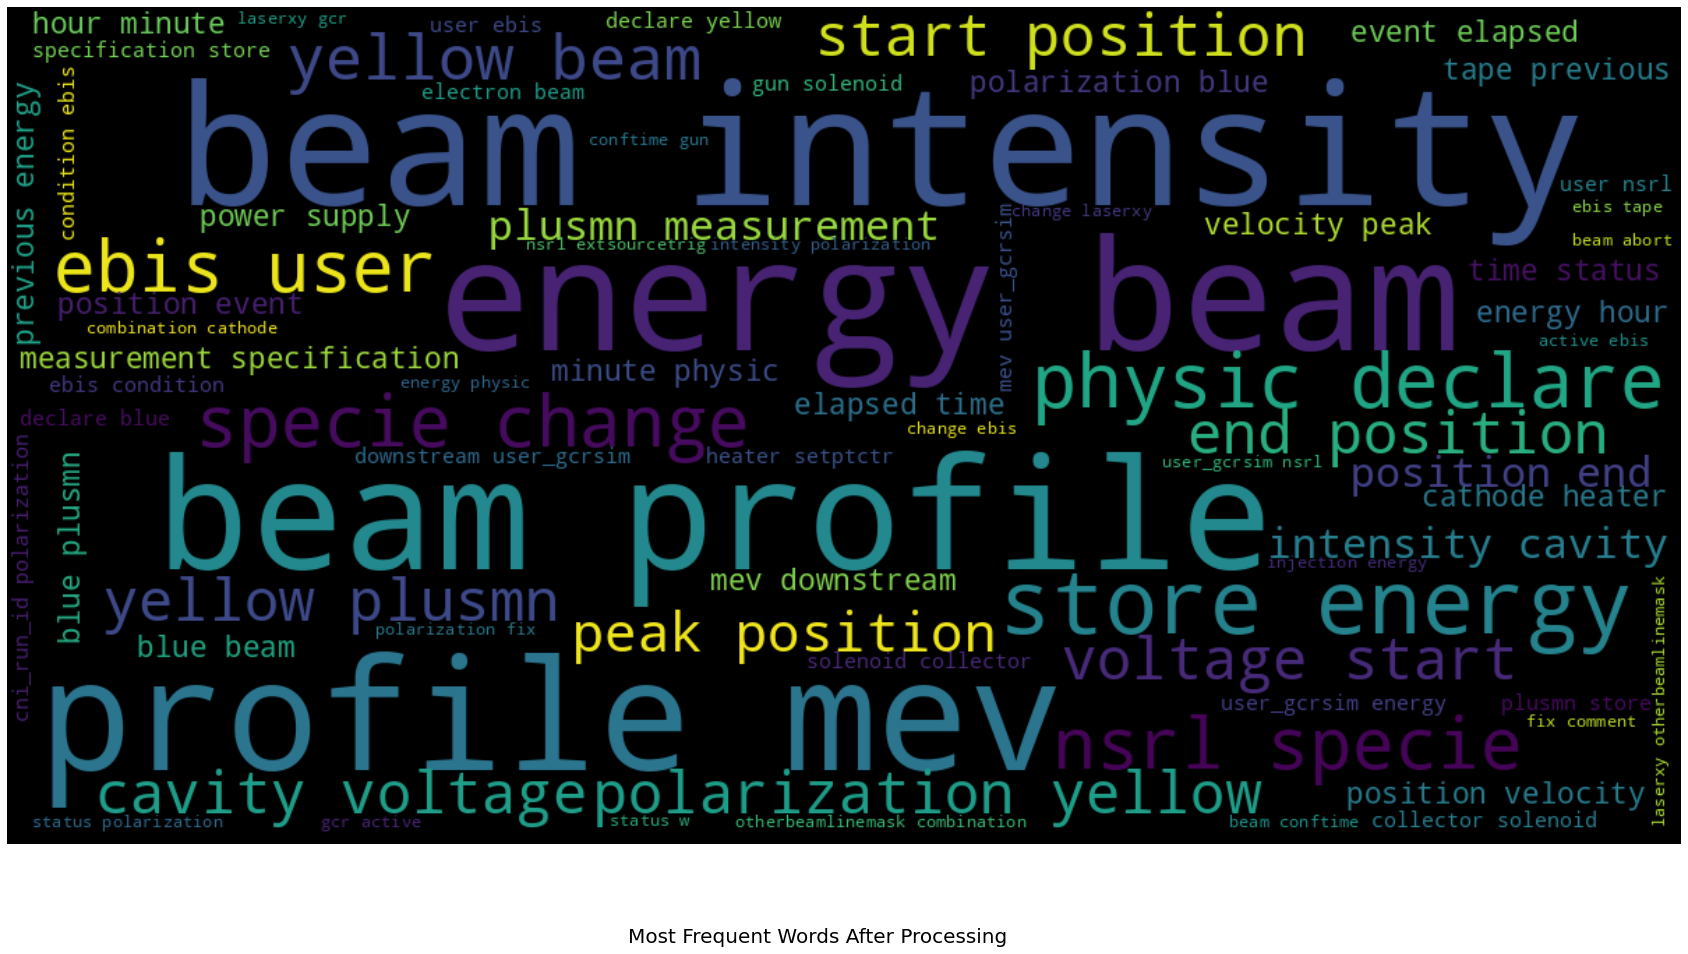

In [11]:
#Which words occurred the most
import wordcloud
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    text = ""
    for v in data:
        for i in v:
            text += " "+ i
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random
).generate(text)

    fig = plt.figure(1, figsize=(30, 30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.show()
show_wordcloud(data['Processed'], "Most Frequent Words After Processing")

Display other word cloud here

### SKLearn Count Vectorizer
#### Load and Split Training Data
Here, we are reading all of the json files that were loaded earlier by the MySQL queries in order to prepare them to have operations conducted on them. The major ones to look at here are the bigger training data set, rhictest, and test. 

test = the large data set of 90 thousand-ish untagged entries
rhictest = 20 thousand-ish untagged entries that are specific to the rhic elog
biggerTrain = 18 thousand-ish tagged entries from the last two years to use as training for our model. 

In [12]:
test = pd.read_json('finaltest.json',lines = True)
rhictest = pd.read_json('rhictest.json',lines = True)
train = pd.read_json('training.json',lines = True)
biggerTrain = pd.read_json('biggertrain.json',lines = True)
failureTest = pd.read_json('failuretest.json', lines = True)

#### Balance Training Data
Upon view of a confusion matrix during the experimentation, there were poor accuracy and classification results. As a result, there was a need to balance the data by getting rid of tags that occurred only a small amount of times, as they would be unable to be caught by the classifier and are only causing errors. The code below finds the occurance of all the tags in the entires, and then adds all the tags that need to be removed into its own list. From there it removes the tags from the dataframe and then prints all the remaining tags in the dataframe. 

In [13]:
#removing tags that occur 3 or less times from the training dataframe
#finding count of each tag    
tag_count = {}
for i in biggerTrain['Tag']:
    if(i not in tag_count.keys()):
        tag_count[i] = 1
    else:
        tag_count[i] += 1 

remove = []
for key,value in tag_count.items():
    if value < 800:
        remove.append(key)
    
for i in remove:
    biggerTrain.drop(biggerTrain[biggerTrain['Tag'] == i].index, inplace = True)
#print(tag_count)
#print(remove)
tag_count = {}
for i in biggerTrain['Tag']:
    if(i not in tag_count.keys()):
        tag_count[i] = 1
    else:
        tag_count[i] += 1 
print(tag_count)
print(len(tag_count))

{'F-MachineSetup': 964, 'R-MachineSetup': 4446, 'R-Failure': 897, 'R-Physics': 3938}
4


Split the training data from the big set and the smaller set into a training set and then a validation set. The ratio used in this scenario is around 20% validation and then 80% training. 

In [14]:
from sklearn.model_selection import train_test_split 
training, valid = train_test_split(train, test_size=0.2, random_state= 1)
bigTraining, bigValid = train_test_split(biggerTrain, test_size = .25, random_state = 1)

#### Creating the Vector Space Model
Use SKLearn package and the separated aspects from before

In [15]:
#Vector Space Model
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer
#Use training Data, with machine tagging to help classify
with StringIO(training['Content'].str.cat(sep='\n')) as fin:
    count_vectorizer = CountVectorizer(analyzer=preprocess_text, ngram_range=(1,3))
    training_countvectors = count_vectorizer.fit_transform(fin)


training_tag = training['Tag']
valid_vectors = count_vectorizer.transform(valid['Content'])
valid_tags = valid['Tag']

In [16]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB() 

# To train the classifier, fit the naive_bayes model on the training 
# set and the tags that have alerady been assigned.
clf.fit(training_countvectors, training_tag) 

from sklearn.metrics import accuracy_score

# to predict our tags 
# we feed the vectorized pretagged set to .predict()
predictions_valid = clf.predict(valid_vectors)


print('Tagging accuracy = {}'.format(
        accuracy_score(predictions_valid, valid_tags) * 100)
     )

Tagging accuracy = 53.31325301204819


#### Naive Bayes Classification

In [17]:
import sklearn
import sklearn.naive_bayes
from sklearn.naive_bayes import BernoulliNB
#gn = BernoulliNB()
from sklearn.naive_bayes import GaussianNB
#gn = GaussianNB()
from sklearn.naive_bayes import ComplementNB
gn = ComplementNB()
gn.fit(training_countvectors, training_tag) 

from sklearn.metrics import accuracy_score

predictions_valid = gn.predict(valid_vectors)

print('Tagging accuracy = {}'.format(
        accuracy_score(predictions_valid, valid_tags) * 100)
     )
#gn.fit(train_countvectors,train_tags)

Tagging accuracy = 55.22088353413655


In [18]:
#Use all the training data and then run it on the data
with StringIO(train['Content'].str.cat(sep='\n')) as fin:
    count_vectorizer = CountVectorizer(analyzer=preprocess_text, ngram_range=(1,4))
    train_countvectors = count_vectorizer.fit_transform(fin)

train_tags = train['Tag']

failure_countvectors = count_vectorizer.transform(failureTest['Content'])
#test_countvectors = count_vectorizer.transform(test["Content"])

In [19]:
clf = MultinomialNB() 
clf.fit(train_countvectors,train_tags) 
predictions = clf.predict(failure_countvectors)
print(len(predictions))
failureTest['Predicted_Tag'] = predictions
#print(data['Predicted_Tag'])
print(failureTest)

8
        Id                                            Content  Machine  \
0  1499766  While turning on various Booster supplies, the...      NaN   
1  1505830  <p>Paul Sampson reports a collapsed cable tray...      NaN   
2  1512311  MCR is trying to coordinate a Booster access t...      NaN   
3  1524461  <p>There has been a site wide loss of power.&n...      NaN   
4  1524884  A. Marusic is unable to ramp bi9-snk7-2.3-ps. ...      NaN   
5  1533728  RHIC is at injection. Tuning adjustments to ac...      NaN   
6  1534892  <p>V. Schoefer reports <a href=http://www.cado...      NaN   
7  1561352  <p>J. Sandberg called to report there is a cur...      NaN   

            TIMESTAMP   Predicted_Tag  
0 2021-09-20 11:40:49       F-Failure  
1 2021-10-22 17:11:54             ags  
2 2021-11-10 20:52:21       R-Failure  
3 2021-12-03 13:57:32       R-Failure  
4 2021-12-03 22:34:26       R-Failure  
5 2021-12-12 19:01:03  R-MachineSetup  
6 2021-12-13 18:11:00       R-Failure  
7 2022-01-1

In [20]:
rhic_vectors = count_vectorizer.transform(rhictest["Content"])
rhic_predictions = clf.predict(rhic_vectors)
rhictest['Predicted_tag'] = rhic_predictions
print(rhictest)

            Id                                            Content  Machine  \
0      1550104  <br>Polarization For Yellow 2 H Target1: <a hr...      NaN   
1      1550105  Ramp to Store Conditions Started:<br><table bo...      NaN   
2      1550106                                            Physics      NaN   
3      1550107  Fill 32926 (ramp 2): <b>Blue ramp efficiency: ...      NaN   
4      1550108                              RatView with orbstats      NaN   
...        ...                                                ...      ...   
20952  1653374  Changed fill number to 33358.<input type=hidde...      NaN   
20953  1653773  Changed fill number to 33359.<input type=hidde...      NaN   
20954  1654066  Changed fill number to 33360.<input type=hidde...      NaN   
20955  1654082  Changed fill number to 33361.<input type=hidde...      NaN   
20956  1654404  Changed fill number to 33362.<input type=hidde...      NaN   

                TIMESTAMP   Predicted_tag  
0     2022-01-01 00

### TF-IDF Vector Representation (Term Frequency-inverse Document Frequency)

#### Count Vectorizer -> TF-IDF

In [21]:
## Get the TF-IDF vector representation of the data
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
training_tfidf = tfidf_transformer.fit_transform(training_countvectors)
print ('Dimension of TF-IDF vector :' , training_tfidf.shape)

Dimension of TF-IDF vector : (3981, 3256)


In [22]:
#Use training Data, with machine tagging to help classify
count_vectorizer = CountVectorizer(analyzer=preprocess_text, ngram_range=(1,3))
bigTraining_countvectors = count_vectorizer.fit_transform(bigTraining['Content'])


bigTraining_tag = bigTraining['Tag']
bigValid_vectors = count_vectorizer.transform(bigValid['Content'])
bigValid_tags = bigValid['Tag']

## Get the TF-IDF vector representation of the data
bigTraining_tfidf = tfidf_transformer.fit_transform(bigTraining_countvectors)
print ('Dimension of TF-IDF vector :' , bigTraining_tfidf.shape)

from sklearn.naive_bayes import ComplementNB
gn = ComplementNB()
print(len(bigTraining_tag))
gn.fit(bigTraining_tfidf, bigTraining_tag) 
bigPredictions_valid = gn.predict(bigValid_vectors)

Dimension of TF-IDF vector : (7683, 1520)
7683


#### Naive Bayes Classification

In [23]:
from sklearn.naive_bayes import ComplementNB
gn = ComplementNB()

gn.fit(training_tfidf, training_tag) 

#predict tags to be compared against
predictions_valid = gn.predict(valid_vectors)

print('ComplementNB Tagging accuracy = {}'.format(
        accuracy_score(predictions_valid, valid_tags) * 100)
     )

ComplementNB Tagging accuracy = 54.81927710843374


In [24]:
train_tfidf = tfidf_transformer.fit_transform(train_countvectors)
gn.fit(train_countvectors,train_tags) 
predictions = gn.predict(failure_countvectors)
print(len(predictions))
failureTest['Predicted_Tag'] = predictions
#print(data['Predicted_Tag'])
#with pd.option_context('display.max_rows', None, 'display.max_columns', None,'expand_frame_repr', False):  # more options can be specified also
#    print(failureTest)

8


# Confusion Matrix and Validating Classifier

In [25]:
# Accuracy score is not enough, we need to perform recall, fscore, precision
# I create a confusion matrix and calculate scores from that precision
def confusion_matrix_and_score_pth(y,ypredicted):
    
    #The lenth of y and ypredicted must have the same length
    if(len(y)!=len(ypredicted)):
        return "Found input variables with inconsistent numbers of samples",len(y),len(ypredicted)
    
    uniq_element     = (set(y)|set(ypredicted))
    
    
    #Creating a dictionary in order to be sure in adding to the matrix
    dictionary = {}
    count = 0
    
    for _ in uniq_element:
        dictionary[_] = count
        count = count+1
    list_predictions = list(uniq_element)
    #Changing class labels
    y = [dictionary.get(_) for _ in y]
    ypredicted = [dictionary.get(_) for _ in ypredicted]
    #print(y)
    actual_tags = {}
    for i in y:
        if list_predictions[i] not in actual_tags:
            actual_tags[list_predictions[i]] = 1
        else:
            actual_tags[list_predictions[i]] += 1
    print("Actual Tag Counts:",actual_tags)

    predicted = {}
    for i in ypredicted:
        if list_predictions[i] not in predicted:
            predicted[list_predictions[i]] = 1
        else:
            predicted[list_predictions[i]] += 1
    print("\n Predicted Tag Counts:",predicted)

    #Declaring necessary variables
    length          = len(uniq_element)
    confusion_matrix = np.zeros((length,length))
    correct_tokens   = 0
    recall           = 0
    precision        = 0
    
    #Creating confusion matrix
    for i,j in zip(y,ypredicted):
        confusion_matrix[i][j] += 1
     
    #Calculating accuracy, recall and f1 score  
    vertical_summation = confusion_matrix.sum(axis=0)
    horizontal_summation = confusion_matrix.sum(axis=1)
    for _ in range (confusion_matrix.shape[0]):
        correct_tokens += confusion_matrix[_][_]
        if (vertical_summation[_] != 0):
            recall += confusion_matrix[_][_]/vertical_summation[_]
        if (horizontal_summation[_]  != 0):
            precision += confusion_matrix[_][_]/horizontal_summation[_]
    
    accuracy  = correct_tokens/np.sum(confusion_matrix)
    recall    = recall/confusion_matrix.shape[0]
    precision = precision/confusion_matrix.shape[0]
    
    f_score = (2*recall*precision)/(recall+precision)
    #print("Input Class Labels:Class labels for this method",dictionary)
    print('Confusion matrix is')
    #np.set_printoptions(threshold=sys.maxsize, suppress = True)
    np.set_printoptions()
    print(confusion_matrix)
    print("Accuracy Score is ", accuracy*100,'%')
    print("Recall Score is ", recall*100,'%')
    print("Precision Score is ", precision*100,'%')
    print("FScore is ", f_score*100,'%')


    #Confusion Matrix Graph
    import seaborn as sns

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Tags by Index')
    ax.set_ylabel('Actual Tags By Index ')

    ## Ticket labels - List must be in alphabetical order

    ## Display the visualization of the Confusion Matrix.
    plt.show()
 

#### Classification Results

Actual Tag Counts: {'R-Physics': 955, 'R-MachineSetup': 1121, 'F-MachineSetup': 266, 'R-Failure': 220}

 Predicted Tag Counts: {'R-Physics': 979, 'R-MachineSetup': 1044, 'F-MachineSetup': 288, 'R-Failure': 251}
Confusion matrix is
[[990.  59.  39.  33.]
 [ 31. 180.   2.   7.]
 [  8.   2. 922.  23.]
 [ 15.  10.  16. 225.]]
Accuracy Score is  90.43715846994536 %
Recall Score is  84.71086649930868 %
Precision Score is  87.81578898844008 %
FScore is  86.23538845635889 %


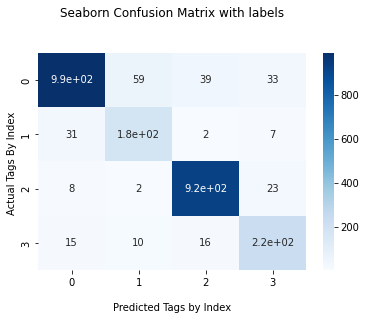

In [26]:
#Confusion Matrix on training data
confusion_matrix_and_score_pth(bigValid_tags,bigPredictions_valid)

##### What does this mean for our model?

Let's Draw out the confusion matrix using a data visualization technique to see if it yields better results.

## Word2Vec Model

#### Bigram Phrases

In [27]:
from gensim.models.phrases import Phrases, Phraser
sent = [row for row in data['Processed']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
#print(bigram[sent])
#print(sent)
sentences = bigram[sent]

In [28]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

14704

In [29]:
#What are the ten most frequent words including common bigram phrases
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

['beam', 'ebis', 'yellow', 'blue', 'energy', 'change', 'polarization', 'position', 'energy/beam_profile', 'end']


#### Create Word2Vec Skip Gram Model

In [30]:
import gensim
import multiprocessing
from gensim.models import Word2Vec
from time import time
t = time()
cores = multiprocessing.cpu_count()
# initialize skipgram model
sg_model = Word2Vec(min_count=10, vector_size = 200,
                    window=2 , sg = 1,
                    sample=5e-5, alpha=0.03, 
                    min_alpha=0.0007, negative=20, workers = cores-1)


token_list = [sen for sen in data['Processed']]
#token_list = [sen for sen in biggerTrain['Processed']]

# build model vocabulary
#sg_model.build_vocab(token_list)
sg_model.build_vocab(sentences, progress_per = 10000)

# train the model
#sg_model.train(token_list, total_examples=sg_model.corpus_count, epochs=300, report_delay=1)
sg_model.train(sentences, total_examples=sg_model.corpus_count, epochs=300, report_delay=1)


print('Time to build Skip gram model vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build Skip gram model vocab: 4.84 mins


In [31]:
vocab_len = len(sg_model.wv)
#print(list(sg_model.wv.key_to_index))
#print(sg_model.wv)
print(vocab_len)
#sg_model.wv.__getitem__('polarization')

3791


In [32]:
print(sg_model.wv.most_similar('polarization')[:5])
print(sg_model.wv.most_similar('blue')[:5])

[('hour_minute', 0.5414149761199951), ('physic_declare', 0.536996066570282), ('xfmr_graph', 0.5369628667831421), ('time_status', 0.5284059643745422), ('event_elapsed', 0.5241406559944153)]
[('yellow', 0.8432851433753967), ('w-wfd_unreliable', 0.5985417366027832), ('fill_summary', 0.5506948232650757), ('xfmr_graph', 0.5411526560783386), ('hour_minute', 0.5379417538642883)]


#### Word2vec Embeddings

In [33]:
biggerTrain['Processed'] = biggerTrain.apply(lambda row: preprocess_text(row['Content']), axis=1)

In [34]:
# functions for Vector Averaging with word2Vec
def w2v_embeddings(text,w2v_model,dimension):
    #print(text)
    if len(text) < 1:
        return np.zeros(dimension)
    else:
        vectorized = [w2v_model.wv[word] if word in w2v_model.wv else np.random.rand(dimension) for word in text] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)     

def get_w2v_embeddings(text,w2v_model,dimension):
        embeddings = text.apply(lambda x: w2v_embeddings(x, w2v_model,dimension))
        return list(embeddings)

In [35]:
train_embeddings_sg_model  = get_w2v_embeddings(biggerTrain['Processed'],sg_model,dimension=200)

### Keras Neural Network

In [36]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.layers import Embedding
tokenizer_obj=Tokenizer()

# to builds the word index
tokenizer_obj.fit_on_texts(token_list)
#token list is the list of all preprocessed texts that have been tokenized, lemmanized, stop words removed.

# to turns strings into lists of integer indices.
sequences=tokenizer_obj.texts_to_sequences(token_list)

# pad_sequences is used to ensure that all sequences in a list have the same length
entries_padded= pad_sequences(sequences,maxlen=50,truncating='post',padding='post')

# creating training set
x_train = entries_padded[:17427]
x_train = np.asarray(x_train)

targets =  [target for target in biggerTrain['Tag']]
targets = np.asarray(targets)

# set of all word and their sequence now
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))
vocab_size = len(word_index)+1
#print(x_train)

Number of unique words: 14095


#### Word2Vec Embedding Layer

In [37]:
# function to generate embeeding layer weights i.e. embeeding_matrix
def generate_word2vec_embeeding_matrix(word_vector_model, dimension, vocab_size= vocab_size, word_index =word_index):
    embedding_matrix=np.zeros((vocab_size,dimension))
    for word,i in tqdm(word_index.items()):
        if i > vocab_size:
            continue
        if word in word_vector_model.wv:  
            emb_vec=word_vector_model.wv.__getitem__(word)
            embedding_matrix[i]=emb_vec
    return embedding_matrix

def generate_pretrained_embeeding_matrix(word_vector_model, dimension, vocab_size= vocab_size, word_index =word_index):
    embedding_matrix=np.zeros((vocab_size,dimension))
    for word,i in tqdm(word_index.items()):
        if i > vocab_size:
            continue
        if word in word_vector_model:  
            emb_vec=word_vector_model[word]
            embedding_matrix[i]=emb_vec
    return embedding_matrix

In [38]:
from keras.layers import Embedding

embedding_matrix = generate_word2vec_embeeding_matrix(sg_model, dimension = 200)

embedding_layer = Embedding(vocab_size, output_dim= 200, weights=[embedding_matrix], 
                                     input_length=50, trainable=False)

100%|██████████| 14095/14095 [00:00<00:00, 672453.11it/s]


In [39]:
import keras
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    
]
from keras.models import Sequential
from keras.layers import Flatten, Dense
dnn_model = Sequential()
dnn_model.add(embedding_layer)
dnn_model.add(Flatten())
dnn_model.add(Dense(1, activation='softmax'))

dnn_model.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

print(dnn_model.layers)
dnn_model.layers

dnn_model.summary()

history = dnn_model.fit(np.array(x_train),  y = np.array(targets),
                    epochs=20, batch_size = 100,
                    validation_split = 0.2, callbacks= my_callbacks)

[<keras.layers.core.embedding.Embedding object at 0x7fbb362963d0>, <keras.layers.reshaping.flatten.Flatten object at 0x7fbb3c655a10>, <keras.layers.core.dense.Dense object at 0x7fbac986bb90>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           2819200   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 2,829,201
Trainable params: 10,001
Non-trainable params: 2,819,200
_________________________________________________________________


ValueError: Data cardinality is ambiguous:
  x sizes: 13941
  y sizes: 10245
Make sure all arrays contain the same number of samples.

## K-Means Clustering of Word2Vec

In [40]:
# importing KMeans library of sklearn
from sklearn.cluster import KMeans

def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

# we assign the value to X
X = sg_model.wv[sg_model.wv.key_to_index]

In [41]:
kmeans3 = KMeans(3)
%time km3 = kmeans3.fit_predict(X)
kmeans4 = KMeans(4)
%time km4 = kmeans4.fit_predict(X)
kmeans5 = KMeans(5)
%time km5 = kmeans5.fit_predict(X)
kmeans6 = KMeans(6)
%time km6 = kmeans6.fit_predict(X)
kmeans7 = KMeans(7)
%time km7 = kmeans7.fit_predict(X)
kmeans8 = KMeans(8)
%time km8 = kmeans8.fit_predict(X)

CPU times: user 6.89 s, sys: 6.79 s, total: 13.7 s
Wall time: 707 ms
CPU times: user 10.2 s, sys: 9.21 s, total: 19.4 s
Wall time: 992 ms
CPU times: user 10.7 s, sys: 9.64 s, total: 20.4 s
Wall time: 1.06 s
CPU times: user 13.1 s, sys: 11.2 s, total: 24.3 s
Wall time: 1.26 s
CPU times: user 13.3 s, sys: 11.7 s, total: 25 s
Wall time: 1.3 s
CPU times: user 16.9 s, sys: 14.5 s, total: 31.3 s
Wall time: 1.64 s


#### Silhouettte Test

-0.042017836
-0.048611633
-0.04843778
-0.056874227
-0.062003944
-0.0653233


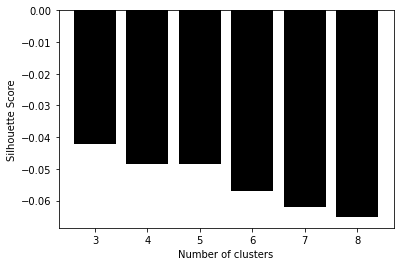

CPU times: user 4.39 s, sys: 15.3 s, total: 19.7 s
Wall time: 1.09 s


In [42]:
from sklearn.metrics import silhouette_score

def plot_silhouette(kms,data,nclusts):
    
    silhouette = []
    for i in kms:
        score = silhouette_score(data,i)
        print(score)
        silhouette.append(score)
    
    
    plt.bar(nclusts, silhouette,color = 'black')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

%time plot_silhouette([km3,km4,km5,km6,km7,km8],X,[3,4,5,6,7,8])

### Dimensional Reduction of Word2Vec vectorized representation

#### T-SNE Dimensional Reduction

In [43]:
#turn into x-y coordinates using t-SNE
from sklearn.manifold import TSNE
import numpy as np
words_tsne = []
embeddings_tsne = []
for word in list(sg_model.wv.key_to_index):
    embeddings_tsne.append(sg_model.wv[word])
    words_tsne.append(word)
    
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_2d.fit_transform(embeddings_tsne)

/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              0   x_values  y_values
0     -5.484278  -5.484278 -3.217770
1      2.845025   2.845025  4.745697
2     -1.864426  -1.864426  4.069426
3     -1.865394  -1.865394  4.020270
4     -1.123901  -1.123901  5.648592
...         ...        ...       ...
3786  -0.872431  -0.872431  2.157641
3787  -0.195852  -0.195852 -0.048054
3788 -13.650134 -13.650134  0.063329
3789  -1.940992  -1.940992 -1.938849
3790  -3.271919  -3.271919 -0.582418

[3791 rows x 3 columns]


<Figure size 1152x648 with 0 Axes>

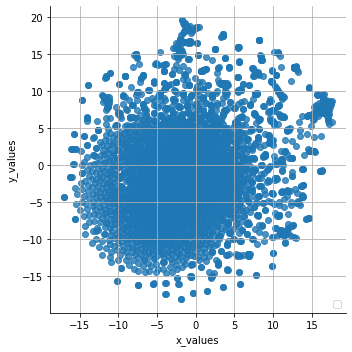

In [44]:
import matplotlib.cm as cm

def tsne_plot_2d(label, embeddings, words=[], a=1): 
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    set_complete = pd.DataFrame(x)
    set_complete['x_values'] = set_complete.iloc[0:, 0]
    set_complete['y_values'] = y
    #set_complete['Cluster'] = assigned_clusters
    print(set_complete)
    #sns.lmplot(x = 'x_values', y = 'y_values', fit_reg = False, data = set_complete,hue = "Cluster")
    sns.lmplot(x = 'x_values', y = 'y_values', fit_reg = False, data = set_complete)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_2d('t-SNE MODEL', embeddings_2d, a=0.1)

T-SNE display is not chosen over PCA because PCA has better displays and easier convience in our context.

### PCA Dimensional Reduction

In [45]:
#turn into x-y coordinates for kmeans and clustering
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
vectors = sg_model.wv[sg_model.wv.key_to_index]
words = list(sg_model.wv.key_to_index)
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

In [46]:
#Let's see how our graph dataset looks like now
print(PCA_data_complet)

              word  x_values  y_values
0             beam -0.553699  0.145073
1             ebis  0.353596 -0.187325
2           yellow  0.006854  0.186397
3             blue -0.122018  0.201698
4           energy -0.569124  0.989653
...            ...       ...       ...
3786        grigor  0.017423 -0.714312
3787      ignitron  0.796982 -0.321437
3788       outlier -1.599692  0.515392
3789  alarmdisplay -0.519754 -1.432092
3790   b-qtrimh-ps  0.493971 -0.656116

[3791 rows x 3 columns]


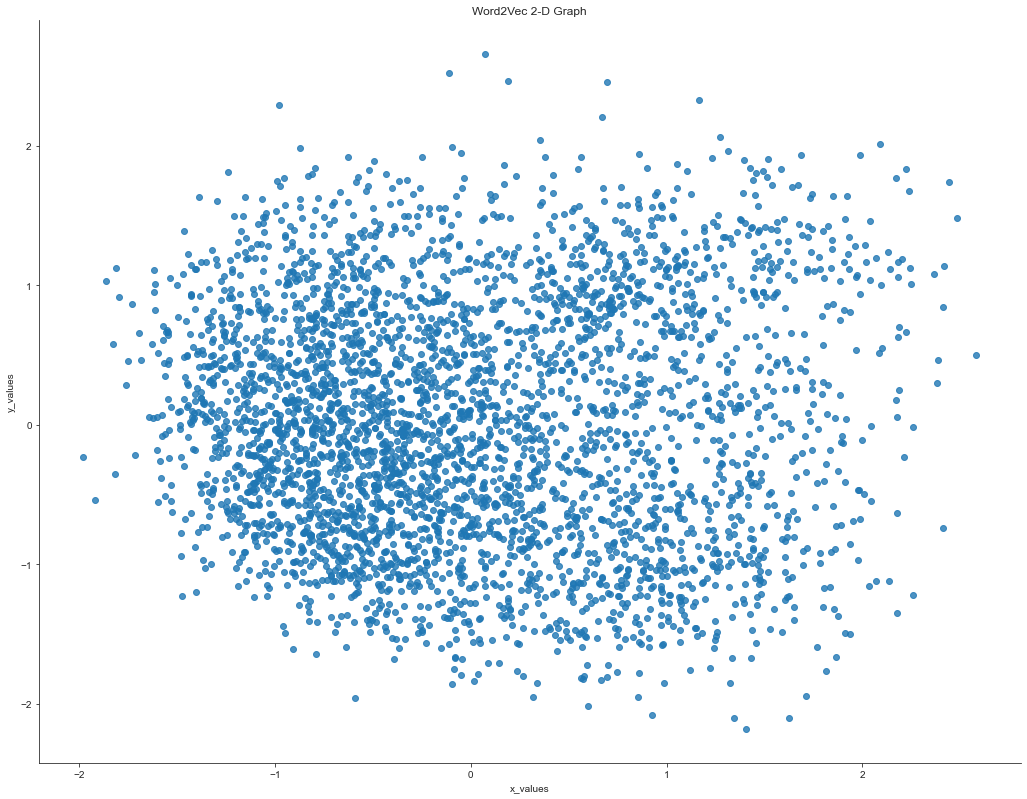

In [47]:
sns.set_style('ticks')
fig = sns.lmplot(x='x_values', y='y_values',
           data = PCA_data_complet,
           fit_reg=False,
           legend=True)
fig = plt.gcf()
fig.set_size_inches(16, 12)
plt.title("Word2Vec 2-D Graph")
plt.show()

#### Cluster Word2Vec words using NLTK KMeans Clusterer

In [48]:
#X was assigned early, but it is displayed again here so you can see. 
X = sg_model.wv[sg_model.wv.key_to_index]

from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS= 6
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.euclidean_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print (assigned_clusters)

#### 2-Dimensional Cluster Representation

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


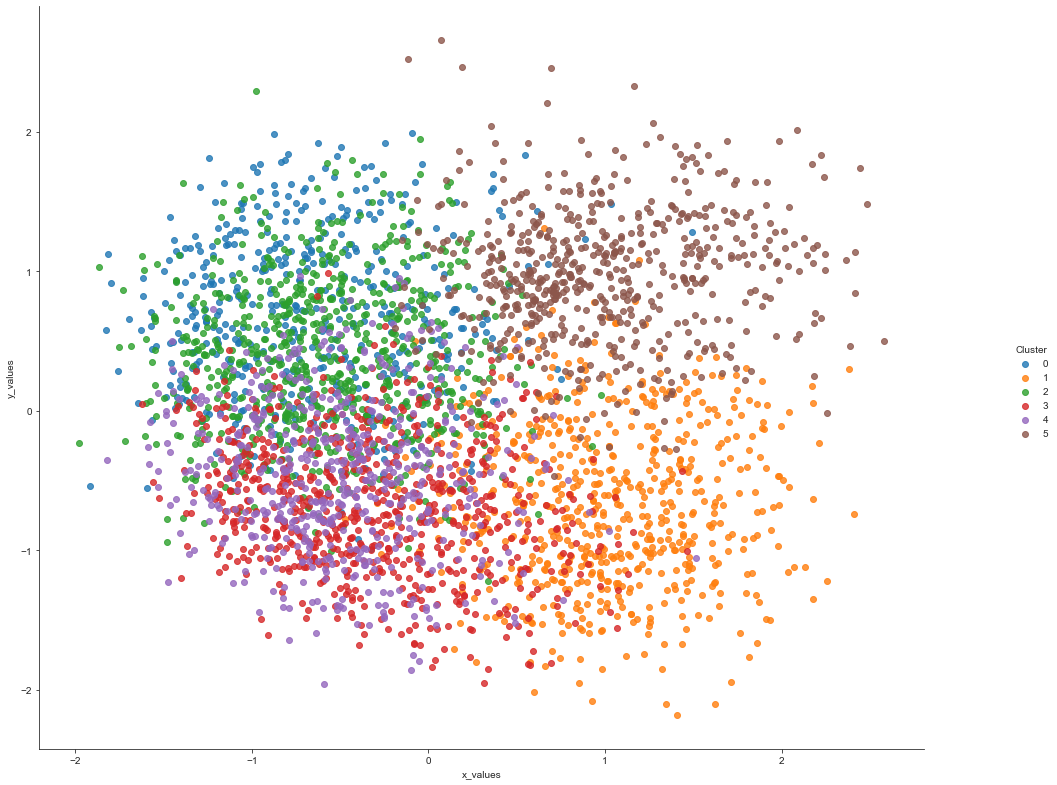

In [49]:
PCA_data_complet['Cluster'] = assigned_clusters

sns.set_style('ticks')
fig = sns.lmplot(x='x_values', y='y_values',
           data = PCA_data_complet,
           fit_reg=False,
           legend=True,
           hue = 'Cluster')
fig = plt.gcf()
fig.set_size_inches(16, 12)
plt.show()

Let's see what words got clustered together

In [50]:
words = list(sg_model.wv.key_to_index)
for i, word in enumerate(words):
    words_clusters = word +":" + str(assigned_clusters[i])
    print(words_clusters)


beam:3
ebis:3
yellow:3
blue:3
energy:3
change:3
polarization:3
position:3
energy/beam_profile:5
end:3
user:3
user_gcrsim:5
physic_declare:5
nsrl_specie:5
intensity:3
fill:3
store:3
peak:0
ramp:3
voltage_start:5
intensity_cavity:5
event_elapsed:5
time_status:5
position_velocity:5
plusmn_measurement:5
plusmn:5
time:3
hour_minute:5
mev:5
tape_-previous:5
solenoid:0
condition:5
mev_downstream:5
specification_store:5
start:3
cni_run_id_polarization:5
run:3
power_supply:3
rhic:3
solenoid_collector:5
conftime_gun:5
nsrl_extsourcetrig:5
measurement:3
work:3
injection:3
trip:3
comment:3
linac:3
back:3
+/-_fix:5
set:3
's:3
abort:3
electron:0
nsrl:3
mcr:3
check:3
current:3
turn:3
laserxy_otherbeamlinemask:5
calibration:0
issue:3
proton:3
pattern:3
combination_cathode:5
n't:3
heater_setptctr=off:5
ramp_efficiency:5
complete:3
alarm:3
shift:3
supply:3
data:3
bbq:2
drop:3
scan:0
find:3
calibration_begin:5
problem:3
physic:3
bunch:3
cathode_heater:5
tune:3
hour:3
booster:3
minute:3
voltage:3
low:3
ta

#### 3-Dimensional Cluster Representation

In [51]:
#turn into x-y-Z coordinates for kmeans and clustering

# fit a 3-D PCA model to the vectors
vectors = sg_model.wv[sg_model.wv.key_to_index]
words = list(sg_model.wv.key_to_index)
tpca = PCA(n_components=3)
tPCA_result = tpca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(words)
tPCA_result = pd.DataFrame(tPCA_result)
tPCA_result['x_values'] =tPCA_result.iloc[0:, 0]
tPCA_result['y_values'] =tPCA_result.iloc[0:, 1]
tPCA_result['z_values'] =tPCA_result.iloc[0:, 2]
tPCA_final = pd.merge(words, tPCA_result, left_index=True, right_index=True)
tPCA_final['word'] =tPCA_final.iloc[0:, 0]
tPCA_data_complet =tPCA_final[['word','x_values','y_values','z_values']]
tPCA_data_complet['Cluster'] = assigned_clusters

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


<Figure size 3600x1440 with 0 Axes>

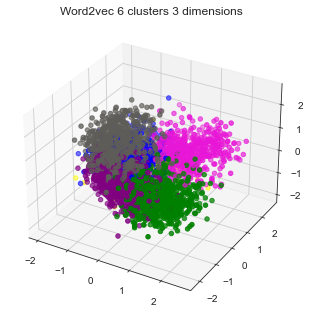

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


<Figure size 3600x1440 with 0 Axes>

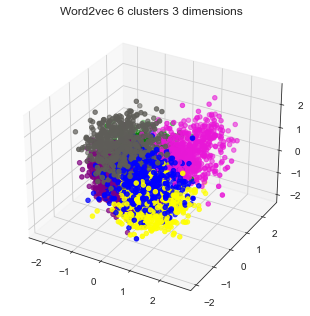

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


<Figure size 3600x1440 with 0 Axes>

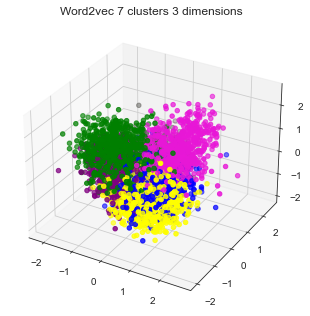

In [52]:
from mpl_toolkits.mplot3d import Axes3D

color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58','#e817d7','#FFFFFF']
color = [color_code[i] for i in list(tPCA_data_complet['Cluster'])]
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(tPCA_data_complet['x_values'],tPCA_data_complet['y_values'], tPCA_data_complet['z_values'],c = color)
plt.title("Word2vec 6 clusters 3 dimensions")
plt.show()

color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58','#e817d7','#FFFFFF']
color = [color_code[i] for i in list(tPCA_data_complet['Cluster'])]
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(tPCA_data_complet['y_values'],tPCA_data_complet['x_values'], tPCA_data_complet['z_values'],c = color)
plt.title("Word2vec 6 clusters 3 dimensions")
plt.show()

color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58','#e817d7','#FFFFFF']
color = [color_code[i] for i in list(tPCA_data_complet['Cluster'])]
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(tPCA_data_complet['y_values'], tPCA_data_complet['z_values'],tPCA_data_complet['x_values'],c = color)
plt.title("Word2vec 7 clusters 3 dimensions")
plt.show()

# Doc2Vec Model

In [53]:
def replace_none(X):
    if X == '':
        X = np.nan
    return X

#### Create Tagged Documents

In [54]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
elog_corpus = []
for id,row in enumerate(data['Processed']):       
    elog_corpus.append(
        gensim.models.doc2vec.TaggedDocument(row,[id] )
    )
#print(list(elog_corpus[:10]))
elog_corpus = list(elog_corpus)
print(elog_corpus[:10])

[TaggedDocument(words=['polarization', 'yellow', 'plusmn', 'measurement', 'specification', 'store', 'energy', 'physic', 'declare', 'yellow', 'beam', 'intensity', 'cavity', 'voltage', 'start', 'position', 'end', 'position', 'velocity', 'peak', 'position', 'event', 'elapsed', 'time', 'status', 'w-internal', 'warning', 'logfile'], tags=[0]), TaggedDocument(words=['polarization', 'yellow', 'plusmn', 'store', 'energy', 'physic', 'declare', 'yellow', 'beam', 'intensity'], tags=[1]), TaggedDocument(words=['set', 'velocity', 'generated', 'million', 'event', 'mcr', 'decrease', 'velocity', 'time', 'reach', 'million'], tags=[2]), TaggedDocument(words=['ramp', 'store', 'condition', 'start', 'fill', 'ramp', 'tunemeter', 'ipm', 'orbfb', 'tunefb', 'chromfb', 'blue', 'bbq', 'yellow', 'bbq'], tags=[3]), TaggedDocument(words=['physic'], tags=[4]), TaggedDocument(words=['fill', 'ramp', 'blue', 'ramp', 'efficiency', 'yellow', 'ramp', 'efficiency'], tags=[5]), TaggedDocument(words=['ratview', 'orbstats'], 

#### Build Doc2Vec Model

In [55]:
  
doc_model = Doc2Vec(min_count = 2, vector_size = 300,
                    window = 2, min_alpha= .00025, dm = 1)
doc_model.build_vocab(elog_corpus)
doc_model.train(elog_corpus, total_examples= doc_model.corpus_count, epochs = 100)

In [56]:
# Check a few terms to ensure the model was trained properly.
print(doc_model.wv.similar_by_word('polarization'))
print(doc_model.wv.most_similar('blue'))

[('measurement', 0.7196193337440491), ('plusmn', 0.4971177875995636), ('yellow', 0.4583289921283722), ('intensity', 0.4351126253604889), ('ramp', 0.4271692633628845), ('blue', 0.42379316687583923), ('calibration', 0.41958630084991455), ('emittance', 0.4187973141670227), ('rf', 0.41217878460884094), ('store', 0.4089679419994354)]
[('yellow', 0.9438838958740234), ('store', 0.5289559364318848), ('fill', 0.5149502158164978), ('event', 0.49955788254737854), ('hour', 0.4877528250217438), ('measurement', 0.4833877384662628), ('beam', 0.4783322215080261), ('permit', 0.46053430438041687), ('power', 0.4563039541244507), ('rhic', 0.43829283118247986)]


#### Finding Similar E-Logs

In [57]:
tokens = preprocess_text("cas found a window comparator fault on the tuner window mcr has contacted k hernandez for assistance")
new_vector = doc_model.infer_vector(tokens, alpha = .01, min_alpha = .00025, epochs = 50)
similars = doc_model.dv.most_similar([new_vector])
print(similars)
print('Test String:' + "cas found a window comparator fault on the tuner window mcr has contacted k hernandez for assistance")
for i,entry in enumerate(similars):
    print(str(i) + ": " + data['Content'].iloc[entry[0]])

[(21, 0.7201218605041504), (3561, 0.5721545815467834), (35501, 0.566242516040802), (39124, 0.5618578195571899), (66388, 0.5353104472160339), (66396, 0.5192041397094727), (23433, 0.5189602971076965), (63923, 0.5167765021324158), (8447, 0.5150232911109924), (55254, 0.5125692486763)]
Test String:cas found a window comparator fault on the tuner window mcr has contacted k hernandez for assistance
0: CAS found a window comparator fault on the tuner window. MCR has contacted K. Hernandez for assistance. <br>
1: MCR and CAS are sweeping 2z2 and 2z1.<br>
2: MCR and CAS are going out to sweep sector 2.<br>
3: The access to 2z1 is finished. CAS and MCR are going to sweep 2z1.<br>
4: MCR left a message with P.K. Feng.<br>
5: MCR left a message with D. Donaldson. <br>
6: MCR is mode switching from Au to PP.<br>
7: MCR left a message with K. Hartmann<br>
8: IR6 sweep is complete. CAS and MCR are going out to sweep IR2.<br>
9: Keith Zeno is in MCR tuning the injectors.<br>


In [58]:
tokens = preprocess_text("polarization for yellow 2 h target1 store energy before physics declared yellow beam intensity")
new_vector = doc_model.infer_vector(tokens, min_alpha = .00025, epochs = 100)
similars = doc_model.dv.most_similar([new_vector])
print(similars)
print('Test String:' + "polarization for yellow 2 h target1 store energy before physics declared yellow beam intensity")
for i,entry in enumerate(similars):
    print(str(i) + ": " + data['Content'].iloc[entry[0]])

[(629, 0.79044508934021), (31753, 0.7871640920639038), (6888, 0.7860274910926819), (21177, 0.7787876129150391), (12485, 0.7746415138244629), (25497, 0.7734560370445251), (53932, 0.7728988528251648), (61735, 0.77125084400177), (23021, 0.7698655724525452), (25923, 0.7696099281311035)]
Test String:polarization for yellow 2 h target1 store energy before physics declared yellow beam intensity
0: <br>Polarization For Yellow 2 H Target1: <a href=http://www.cadops2.bnl.gov/elogs/entryList.jsp?DATABY=day&ELOG=P-Carbon-Polar_Stay&DATE=01/02/2022&DIR=none#1550854>47.22 &plusmn 2.45</a><br>Store Energy (254.87) Before Physics Declared, Yellow Beam Intensity: 212.73x10^11<br>
1: <br>Polarization For Yellow 2 H Target5: <a href=http://www.cadops2.bnl.gov/elogs/entryList.jsp?DATABY=day&ELOG=P-Carbon-Polar_Stay&DATE=02/16/2022&DIR=none#1589541>42.55 &plusmn 2.49</a><br>Store Energy (254.21) Before Physics Declared, Yellow Beam Intensity: 223.04x10^11<br>
2: <br>Polarization For Yellow 1 V Target5: <a 

In [59]:
def find_similars(entry = ""):
    tokens = preprocess_text(entry)
    new_vector = doc_model.infer_vector(tokens, min_alpha = .00025, epochs = 100)
    similars = doc_model.dv.most_similar([new_vector], topn = 10)
    print(similars)
    print('Test String: ' + entry)
    for i,entry in enumerate(similars):
        print(str(i+1) + ": " + help_clean(data['Content'].iloc[entry[0]]))

#def find_similars(elog_id = 0):
    
#find_similars("RHIC physics program ran without interruptions over two store.")

In [60]:
#Similar E-Log Test as provided by John Morris
find_similars("I like this LogView display setup as a way to compare Westinghouse and Siemens stability.  The bottom graph in each image shows the field at a time late in the AGS ramp.  The top graph shows the time in cycle when a particular field is reached (9778.6G).  The first image shows a time span including Westinghouse and Siemens.  The second image shows only Westinghouse running.  The third shows Siemens running. I would say that even after Westinghouse improvements, the field was never quite as stable as Siemens.  And due to the difference in ramp rates, the repeatability of reaching a field at a consistent time is much better with Siemens.")

[(46976, 0.8988916873931885), (46975, 0.8828219175338745), (32730, 0.47858279943466187), (26479, 0.4601964056491852), (30284, 0.45401889085769653), (72930, 0.4497465491294861), (44963, 0.44820111989974976), (26480, 0.44639429450035095), (32793, 0.4426523745059967), (17611, 0.43852218985557556)]
Test String: I like this LogView display setup as a way to compare Westinghouse and Siemens stability.  The bottom graph in each image shows the field at a time late in the AGS ramp.  The top graph shows the time in cycle when a particular field is reached (9778.6G).  The first image shows a time span including Westinghouse and Siemens.  The second image shows only Westinghouse running.  The third shows Siemens running. I would say that even after Westinghouse improvements, the field was never quite as stable as Siemens.  And due to the difference in ramp rates, the repeatability of reaching a field at a consistent time is much better with Siemens.
1:  I like this LogView display setup as a way 

In [61]:
find_similars("Cycled the mode <a href=http://www.cadops2.bnl.gov/elogs/entryList.jsp?DATABY=day&amp;ELOG=RHIC&amp;DATE=03/22/2022&amp;DIR=none#1616373>'normal' and 'delayed'</a> which cleared it.<br></p>")

[(53451, 0.8392457962036133), (10117, 0.6162422895431519), (10066, 0.6150100827217102), (30802, 0.6057276725769043), (3027, 0.6007887125015259), (61211, 0.5990396738052368), (30801, 0.5965622067451477), (38349, 0.594645619392395), (57818, 0.5892825126647949), (27323, 0.5827255845069885)]
Test String: Cycled the mode <a href=http://www.cadops2.bnl.gov/elogs/entryList.jsp?DATABY=day&amp;ELOG=RHIC&amp;DATE=03/22/2022&amp;DIR=none#1616373>'normal' and 'delayed'</a> which cleared it.<br></p>
1:  Cycled the mode  'normal' and 'delayed'  which cleared it.  
2: Every other cycle
3: Changed the target insertion time to 0.7s (was 0.9s) to get more events in one cycle. 
4: I cycled the J10-dump-ps.
5: raidus through the cycle
6: 2 cycles
7: I cycled the J10-dump-ps.
8: WXY and RHIC critical devices are enabled. Access control personnel cycled few RHIC zones from NA- CA- NA, which cleared the reachbacks. 
9: J. Mi cycled the abort kicker stby-off-stby-on. This seems to have resolved the issue. 
10

In [62]:
find_similars("Cycled the mode normal and delayed which cleared it")

[(59129, 0.6744591593742371), (59130, 0.6598131656646729), (59131, 0.6477066874504089), (53453, 0.6420428156852722), (17695, 0.6331387758255005), (53452, 0.6317708492279053), (80847, 0.6249712109565735), (80849, 0.6229308843612671), (12341, 0.5961176156997681), (17694, 0.5940573811531067)]
Test String: Cycled the mode normal and delayed which cleared it
1: test with 15 seconds delay, 8 cycles, 
2: test with 15 seconds delay, 8 cycles, 
3: test with 15 seconds delay, 8 cycles, 
4: Cycled to Normal mode and back to delayed two times to get the relays open 
5:  5msec delay sent at 22:19:43    8msec delay at 22:22:35  
6: we cycled to normal mode and back to delayed two times to get the relays open 
7: delay 1800,1850,1900,1850
8: delay 1800
9:                   There was a slight delay on this third one.    
10: Back to the normal 0 delay for local cycles at 22:25:11. 


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

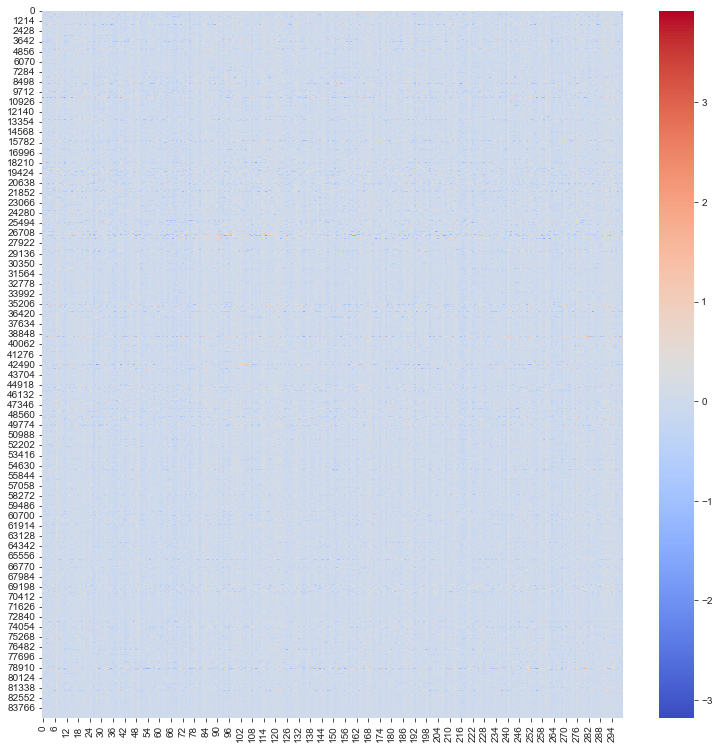

In [63]:
import seaborn as sns
plt.figure(figsize=(13,13))
sns.heatmap(doc_model.docvecs.vectors,cmap="coolwarm")

### K-Means Clustering of Doc2Vec

In [64]:
# importing KMeans library of sklearn
from sklearn.cluster import KMeans

def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

In [65]:
# we have already created doc2vec vector representation in the section of doc2vec, the assign the value to X
X = doc_model.docvecs.vectors

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [66]:
kmeans5 = KMeans(5)
%time km5 = kmeans5.fit_predict(X)

kmeans6 = KMeans(6)
%time km6 = kmeans6.fit_predict(X)

kmeans7 = KMeans(7)
%time km7 = kmeans7.fit_predict(X)

kmeans8 = KMeans(8)
%time km8 = kmeans8.fit_predict(X)

kmeans9 = KMeans(9)
%time km9 = kmeans9.fit_predict(X)

kmeans10 = KMeans(10)
%time km10 = kmeans10.fit_predict(X)

kmeans11 = KMeans(11)
%time km11 = kmeans11.fit_predict(X)

CPU times: user 1min 42s, sys: 46.7 s, total: 2min 28s
Wall time: 7.77 s
CPU times: user 1min 49s, sys: 48.9 s, total: 2min 38s
Wall time: 8.15 s
CPU times: user 1min 41s, sys: 1min 2s, total: 2min 43s
Wall time: 8.41 s
CPU times: user 2min 20s, sys: 1min 9s, total: 3min 30s
Wall time: 10.8 s
CPU times: user 2min 17s, sys: 1min 19s, total: 3min 36s
Wall time: 11.1 s
CPU times: user 2min 11s, sys: 1min 25s, total: 3min 36s
Wall time: 11.1 s
CPU times: user 2min 26s, sys: 1min 33s, total: 3min 59s
Wall time: 12.3 s


#### Analysis of Clusters using WCSS and BCSS

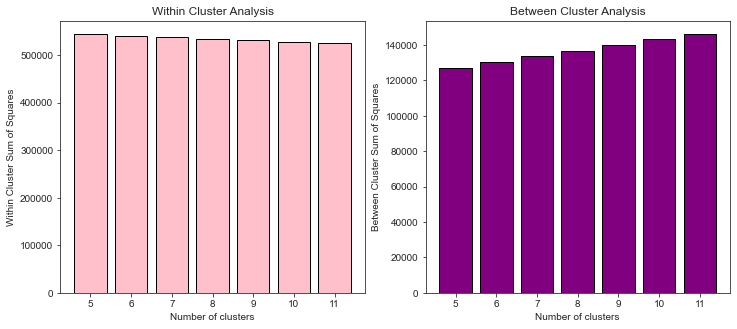

In [67]:
models = [kmeans5, kmeans6, kmeans7, kmeans8, kmeans9, kmeans10,kmeans11]
def plot_WCSS_BCSS(models, data):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in models]
    n_clusts = [5,6,7,8,9,10,11]
    
    ax[0].bar(n_clusts, wcss,color='pink', edgecolor='black', linewidth=1)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Within Cluster Sum of Squares')
    ax[0].set_title('Within Cluster Analysis')
    
    
    ## Plot BCSS 
    n_1 = (float(data.shape[0]) * float(data.shape[1])) - 1.0
    tss = n_1 * np.var(data)
    bcss = [tss - x for x in wcss]
    ax[1].bar(n_clusts,bcss, color = 'purple',edgecolor='black')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Between Cluster Sum of Squares')
    ax[1].set_title('Between Cluster Analysis')
    plt.show()
    

plot_WCSS_BCSS(models,X)

#### Silhouette Test

-0.013852599
0.032150432
-0.019517893
0.020920498
0.01809224
-0.01803713


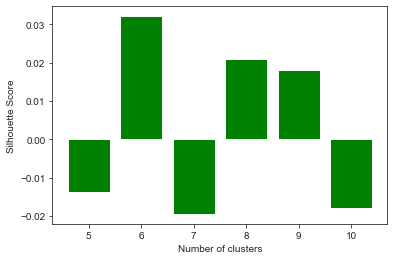

CPU times: user 40min 42s, sys: 2h 14min 16s, total: 2h 54min 59s
Wall time: 11min 3s


In [68]:
from sklearn.metrics import silhouette_score

def plot_silhouette(kms,data,nclusts):
    
    silhouette = []
    for i in kms:
        score = silhouette_score(data,i)
        print(score)
        silhouette.append(score)
    
    
    plt.bar(nclusts, silhouette,color = 'green')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

%time plot_silhouette([km5,km6,km7,km8,km9,km10],X,[5,6,7,8,9,10])

In [69]:
data['Cluster_doc2vec_kmeans'] = kmeans7.labels_

#### Dimensional Reduction of Doc2Vec Vectorized Representation

In [70]:
# Dimension reduction with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3).fit(X)
test_data = pca.transform(X)
centroids_7clust =  pca.transform(kmeans7.cluster_centers_)

##### 3-Dimensional Cluster Representation

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


<Figure size 3600x1440 with 0 Axes>

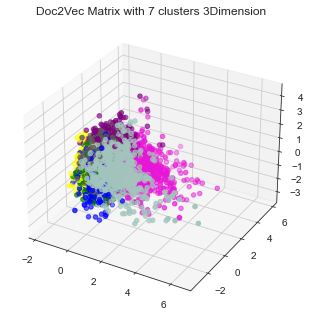

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  if sys.path[0] == '':


<Figure size 3600x1440 with 0 Axes>

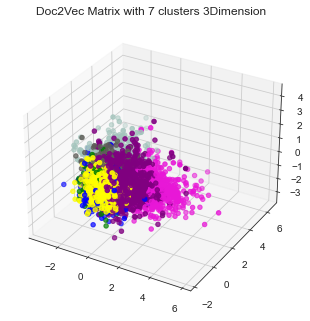

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


<Figure size 3600x1440 with 0 Axes>

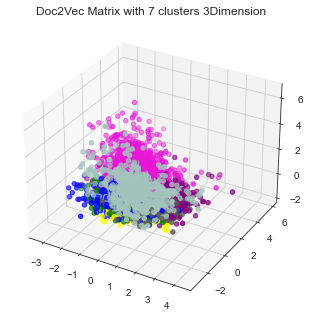

In [71]:
from mpl_toolkits.mplot3d import Axes3D
color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58','#e817d7','#A3C4BC']
color = [color_code[i] for i in list(data['Cluster_doc2vec_kmeans'])]
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 0], test_data[:, 1],test_data[:, 2],c = color)
axis.scatter(centroids_7clust[:, 0], centroids_7clust[:, 1], centroids_7clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 7 clusters 3Dimension")
plt.show()

plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 1],test_data[:, 0],test_data[:, 2],c = color)
axis.scatter(centroids_7clust[:, 0], centroids_7clust[:, 1], centroids_7clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 7 clusters 3Dimension")
plt.show()

plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 2],test_data[:, 1],test_data[:, 0],c = color)
axis.scatter(centroids_7clust[:, 0], centroids_7clust[:, 1], centroids_7clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 7 clusters 3Dimension")
plt.show()

#### 5 Clusters with Doc2Vec

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


<Figure size 3600x1440 with 0 Axes>

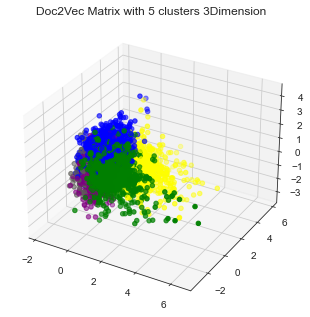

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


<Figure size 3600x1440 with 0 Axes>

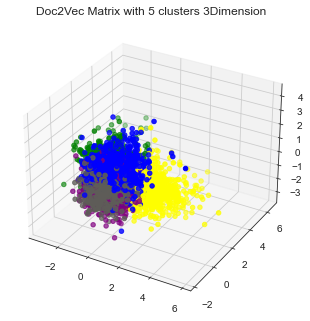

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


<Figure size 3600x1440 with 0 Axes>

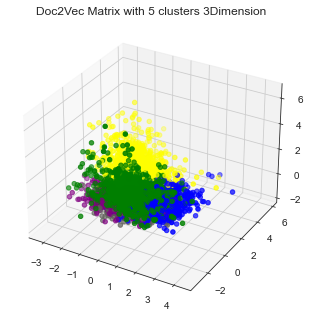

In [72]:
data['Cluster_doc2vec_kmeans_5clust'] = kmeans5.labels_
centroids_5clust =  pca.transform(kmeans7.cluster_centers_)

color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58']
color = [color_code[i] for i in list(data['Cluster_doc2vec_kmeans_5clust'])]
plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 0], test_data[:, 1],test_data[:, 2],c = color)
axis.scatter(centroids_5clust[:, 0], centroids_5clust[:, 1], centroids_5clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 5 clusters 3Dimension")
plt.show()

plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 1],test_data[:, 0],test_data[:, 2],c = color)
axis.scatter(centroids_5clust[:, 0], centroids_5clust[:, 1], centroids_5clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 5 clusters 3Dimension")
plt.show()

plt.figure(figsize=(50,20))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 2],test_data[:, 1],test_data[:, 0],c = color)
axis.scatter(centroids_5clust[:, 0], centroids_5clust[:, 1], centroids_5clust[:,2], marker='*', s=1500, c='#000000')
plt.title("Doc2Vec Matrix with 5 clusters 3Dimension")
plt.show()

In [73]:
#Use training Data, with machine tagging to help classify
count_vectorizer = CountVectorizer(analyzer=preprocess_text, ngram_range=(1,3))
bigTraining_countvectors = count_vectorizer.fit_transform(bigTraining['Content'])


bigTraining_tag = bigTraining['Tag']

## Get the TF-IDF vector representation of the data
bigTraining_tfidf = tfidf_transformer.fit_transform(bigTraining_countvectors)
print ('Dimension of TF-IDF vector :' , bigTraining_tfidf.shape)

test_vectors = count_vectorizer.transform(test['Content'])

gn = ComplementNB()
gn.fit(bigTraining_tfidf, bigTraining_tag) 

test_predictions = gn.predict(test_vectors)



Dimension of TF-IDF vector : (7683, 1520)


KeyboardInterrupt: 

In [ ]:
dictionary_index = {'F-MachineSetup': 0, 'R-MachineSetup': 1, 'R-Failure': 2, 'R-Physics': 3}
tags = []
for i in test_predictions:
    tags.append(dictionary_index[i])
test['tags'] = tags

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


<Figure size 576x864 with 0 Axes>

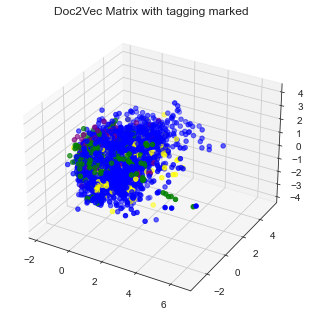

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

color_code= ['#FFFF00', '#008000', '#0000FF', '#800080','#5e5d58','#e817d7','#FFFFFF']
color = [color_code[i] for i in list(test['tags'])]
plt.figure(figsize=(8,12))
axis = Axes3D(plt.figure())
axis.scatter(test_data[:, 0], test_data[:, 1],test_data[:, 2],c = color)
plt.title("Doc2Vec Matrix with tagging marked")
plt.show()

### E-Log Summaries
It could prove to be crucially useful if we are able to create summaries by week using machine learning, or using a start and end date. This would allow people to not have to read or see all the elogs, thus making it easier and faster for consumption. This would be a major milestone. 

First try summarizing using the gensim library and see its results. Gensim is a easy summarizing package from many years ago, but it is worth testing to see how results are. Unfortunately the gensim package no longer supports summarizing.

In [ ]:
def preprocess_to_string(process_list):
    txt = " ".join(process_list)
    return txt

data['Text_Clean'] = data['Content'].apply(lambda x: preprocess_to_string(preprocess_text(x)))

print(data['Text_Clean']) # worked

0        polarization yellow plusmn measurement specifi...
1        polarization yellow plusmn store energy physic...
2        set velocity generated million event mcr decre...
3        ramp store condition start fill ramp tunemeter...
4                                                   physic
                               ...                        
84956    nsrl specie change ebis ebis tape -previous en...
84957    nsrl specie change laserxy gcr=active ebis con...
84958    nsrl energy change tape -previous energy/beam ...
84959    nsrl specie change ebis linac proton tape -pre...
84960    nsrl specie change linac ebis gcr=active ebis ...
Name: Text_Clean, Length: 84961, dtype: object


In [ ]:
data['word_count'] = data['Text_Clean'].apply(lambda x: len(nltk.word_tokenize(str(x))) )
#print(data['word_count'])

/home/cfsd/pkankiya/pythons/nlp_elogs/nlp_elog/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_count', ylabel='Density'>

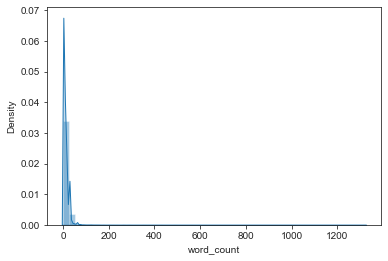

In [ ]:
## plot
sns.distplot(data["word_count"], hist=True, kde=True, kde_kws={"shade":True})

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


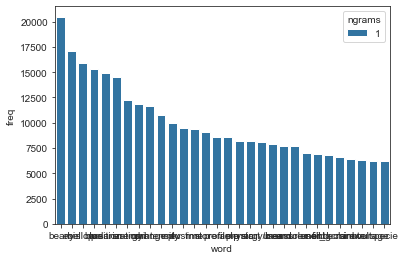

In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(data["Text_Clean"].str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
## plot
sns.barplot(x="word",y="freq", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


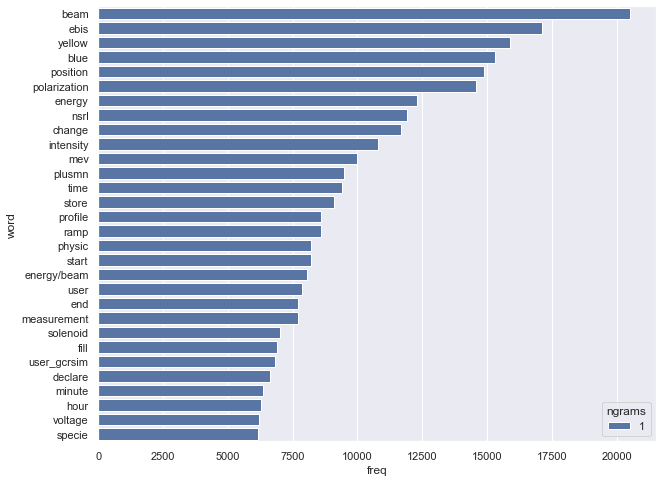

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


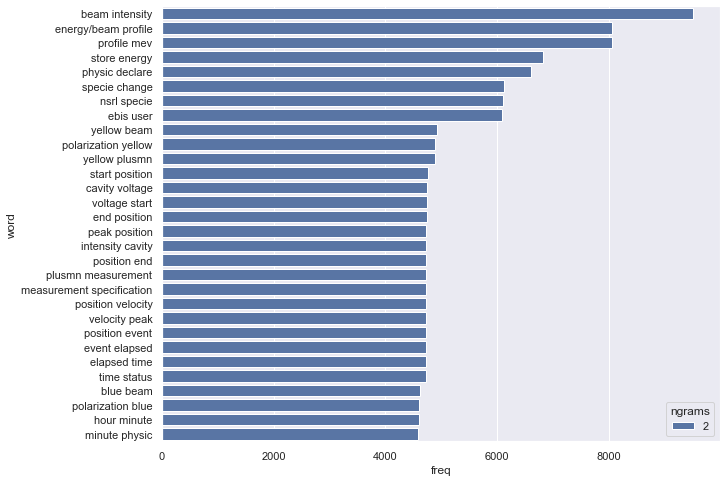

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


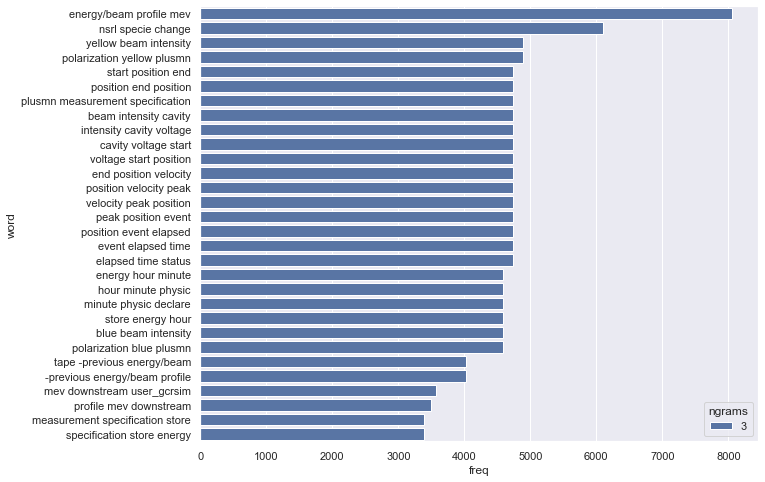

In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(data["Text_Clean"].str.cat(sep=" "))

def word_freq_graph(ngram_amount = 1):
   ngrams = [ngram_amount]
    
   ## calculate
   dtf_freq = pd.DataFrame()
   for n in ngrams:
      dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
      dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                           ["word","freq"])
      dtf_n["ngrams"] = n
      dtf_freq = dtf_freq.append(dtf_n)
      dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
      dtf_freq.sort_values(["ngrams","freq"], ascending=
                           [True,False])
      
   ## plot
   sns.set(rc = {'figure.figsize':(10,8)})
   sns.barplot(x = "freq", y= "word", hue="ngrams",
   data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30),dodge=False)
   plt.show()   

word_freq_graph(1)
word_freq_graph(2)
word_freq_graph(3)

In [ ]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

# Import the LexRank summarizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [ ]:
from datetime import date

new_CLEANER = re.compile('<(?!\/(?=>|\s.*>))\/?.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def clean(html):
    clean = re.sub(new_CLEANER,'',html)
    return clean

def weekly_log(year,month,day):
  date_log = pd.Timestamp(year,month,day)
  week_day = date_log.day_of_week
  month_days = date_log.days_in_month
  if day - week_day <= 0:
    month -= 1
    start_week = pd.Timestamp(year,month,pd.Timestamp(year,month,1).days_in_month + (day-week_day))
  else:  
    start_week = pd.Timestamp(year,month,day-1)#-week_day)
  
  if day + (7-week_day) > month_days:
    end_week = pd.Timestamp(year,month+1, day + (7-week_day) - month_days)  
  else: 
    end_week = pd.Timestamp(year,month,day)# + (7-week_day))
  
  temp = pd.DataFrame()
  temp = data[(data['TIMESTAMP'] > start_week) & (data['TIMESTAMP'] < end_week)]
  summary_string = ""
  for i in temp['Content']:
    i = clean(i)
    summary_string += i
  return ' '.join(summary_string.split())
weekly_log(2022,4,20)



"C. Nieves Rosado assumes BLIP/HEBT watch. BLIP isotope production ran without interruption all shift. Booster has been placed in Restricted Access in preparation for continued RF work in the morning.Driver from Messer called said he would be here around 4:00 am.Got in contact with D. Raparia. He is taking a look. D. Raparia reports the problem seems to be with the source and recommended to contact T. Lehn.Contacted T. Lehn. He will take a look at the source.Source 2 sparking but recovered on it's ownT. Lehn reports that the source appeared to be sparking, but recovered on its own.RHIC complex tours complete. MT secured the CeC gas analyzer.Changed fill number to 33313.Turbine pod 5A- 6A vacuum skid shut down MT restarted vacuum is recovering.Turbine pod 5A- 6A shut down MT restarted vacuum is recovering.Liquid helium tanker is @ main gate. MT out to escort to scalePass ons: P-10 @ STAR Check S-Phenix equipment racks Whenever working on RHIC P.S.'s, use LOTO OPM's in CEPS binder only J

In [ ]:
my_parser = PlaintextParser.from_string(weekly_log(2022,1,12),Tokenizer('english'))
# Creating a summary of 5 sentences.
lex_rank_summarizer = LexRankSummarizer()
lexrank_summary = lex_rank_summarizer(my_parser.document,sentences_count=5)

# Printing the summary
for sentence in lexrank_summary:
  print(help_clean(str(sentence)))

In [ ]:
# Import the summarizer
from sumy.summarizers.lsa import LsaSummarizer
# Parsing the text string using PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
parser=PlaintextParser.from_string(weekly_log(2022,1,12),Tokenizer('english'))
# creating the summarizer
lsa_summarizer=LsaSummarizer()
lsa_summary= lsa_summarizer(parser.document,3)

# Printing the summary
for sentence in lsa_summary:
    print(sentence)

's, use LOTO OPM's in CEPS binder only  change linac phase by 6 degreebeam on diag yag 3Umm yeah, not the result I was expecting PRS 974-8 Booster rf cooling alarm.
Also loaded Attr synchro hold timing but left it off as in archive and turned EBIS DT Ross div snapshot at extraction looks different from earlier.
the orit doesnt look bad?Saving setting with comp coils and trim to correct undulator, 91% transmission40 A solenoids5,000 pulsed 0.29 uALosses 3.6%Zere is signifianc offset in HP ICT ~ 2.5 uA at fll current.


In [ ]:
# Import the summarizer
from sumy.summarizers.luhn import LuhnSummarizer
# Creating the parser
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
parser=PlaintextParser.from_string(weekly_log(2022,1,12),Tokenizer('english'))
#  Creating the summarizer
luhn_summarizer=LuhnSummarizer()
luhn_summary=luhn_summarizer(parser.document,sentences_count=3)

# Printing the summary
for sentence in luhn_summary:
  print(sentence)

bi4-th3-ps bo10-th18-ps bo7-tq6-ps  Details listed below...  bi4-th3-ps 28275:Jan 12 20:25:50 2022:cfe-5a-ps1:tNotifCD: WARNING: :   bo10-th18-ps 28207:Jan 12 20:22:16 2022:cfe-11b-ps1:tNotifCD: WARNING: :   bo7-tq6-ps 28277:Jan 12 20:26:05 2022:cfe-8b-ps1:tNotifCD: WARNING: :    FillPattern before RebucketingFill 32978 (ramp 1):  Blue ramp efficiency:    99.0%, Yellow ramp efficiency:    99.1% RatView with orbstatsIR4 vacuum (left), IR6 vacuum (middle) and IR2 vacuum (right)IR4 vacuum (left), IR6 vacuum (middle) and IR2 vacuum (right)IR4 vacuum (left), IR6 vacuum (middle) and IR2 vacuum (right)  Polarization For Blue 1 V Target3: 45.81 &plusmn 1.93   Measurement Specifications     Store Energy (254.21) Before Physics Declared  &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp  Blue Beam Intensity: 219.59x10^11 Cavity Voltage: 89.94kV    Start Position: 114000    End Position: 124000    Velocity: 1000    Peak Position: 119300    Events Done: 27,042,955    Elapsed Time: 23s   Status: W-WFD 

In [ ]:
# Importing requirements
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration

# Instantiating the model and tokenizer 
my_model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
# Concatenating the word "summarize:" to raw text
text = "summarize:" + weekly_log(2022,4,29)

# encoding the input text
input_ids=tokenizer.encode(text, return_tensors='pt', max_length=512)
# Generating summary ids
summary_ids = my_model.generate(input_ids)
# Decoding the tensor and printing the summary.
t5_summary = tokenizer.decode(summary_ids[0])
print(t5_summary)

ImportError: 
T5ForConditionalGeneration requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.


In [ ]:
import transformers
'''
Summarizes corpus with Bart.
:parameter    
   :param corpus: list - dtf["text"]    
   :param max_len: length of the summary
:return    
    list of summaries
'''
import transformers
from transformers import pipeline

def bart(txt, max_len):    
    nlp = transformers.pipeline("summarization", model = "facebook/bart-large-xsum")    
    lst_summaries = nlp(txt,               
                         min_length= 5)  
    return lst_summaries

## Apply the function to corpus
#print("Original Text: Adjusting to dump half of Yellow ring Spoke to Caitlin who confirmed that the booster scalars stop updating whenever the ppm user switches. This confirms my assumption. Looking at the code also proves that when the application is started it sits on monitoring a single user (in booster) and doesn't update unless the user right clicks and selects the new user from the popup menu.I'm guessing this is not something Operations knows or thinks to do. I'm going to modify the application to automatically switch to the active user. ")

test_case = "I would want to stop putting ETBU2 and EU2 on the EBIS link.I would also like to stop all the associated ET0 events. I could disable EBIST0 and beam line T0s (might require a code change).If I lock out ETBU2, I would stop ETBU2 and associated ETBT0 events. An extra EGE and ETBGE would still come out on the real EBIS link but I don't think that would be a big deal.If I were to take over one of the EBIS users (say User2), I would want to stop putting ETBU2 and EU2 on the EBIS link.I would also like to stop all the associated ET0 events. I could disable EBIST0 and beam line T0s.If I lock out ETBU2, I would stop ETBU2 and associated ETBT0 events. An extra EGE and ETBGE would still come out on the real EBIS link but I don't think that would be a big deal.Vacuum group is coming in to address vacuum issues in sector 1I tuned up protons. PP energy changed to 150 MeV DownStream S_60 (from archived settings)An important question for Ed and Ben. Would you need ETB timing at test EBIS too?An important question for Ed and Ben. Would you need ETB timing too?New EnergySpecific 150 MeV DownStream S_60 PP file created. Booster Extraction Energy 153.800071401359 MeV R-line Rigidity 2.16954 Tm Foil Thickness 0.5Tuned up 150 MeV protons. Lowering injection field by 4 Guass made the most gain. Extraction efficiency is still terrible. I think that is just a matter of how large the beam is. PP energy changed to 100 MeV DownStream User_GCRSim (from archived settings)H scrape lossesNew EnergySpecific 100 MeV DownStream User_GCRSim PP file created. Booster Extraction Energy 105.80006012446 MeV R-line Rigidity 2.16954 Tm Foil Thickness 0.5M. Maier is in. New EnergySpecific 100 MeV DownStream S_60 PP file created. Booster Extraction Energy 105.80006012446 MeV R-line Rigidity 2.16954 Tm Foil Thickness 0.5PP energy changed to 250 MeV DownStream S_60 (from archived settings)K. Zeno is finished with the User 7 beam. The beam request has been removed from this supercycle. Si11 energy changed to 600 MeV DownStream User_GCRSim (from archived settings)We are turning off LTB DH1 for the evening. A. Zelenski has been contacted to set up the user 5 study pulse. Closed Blue Longi KickerBLIP energy = 200 MeVBLIP energy = 200 MeVBLIP energy = 200 MeVBLIP energy = 200 MeVblip.BLIP-MW1blip.BLIP-MW1BLIP energy = 200 MeVThe Booster main magnet has been set to standby. RS LOTO has been applied to the Booster via a Booster CA/Sweep key. CAS has been notified that they are DEC as there will be no OC on duty overnight. MCR will remained staffed with Operators overnight for BLIP/HEBT watch. The Booster main magnet has been set to standby. RS LOTO has been applied to the Booster via a Booster CA/Sweep key. CAS has been notified that they are DEC as there will be no OC on duty overnight. MCR will remained staffed with Operators overnight for BLIP/HEBT watch. The Booster main magnet has been set to standby. RS LOTO has been applied to the Booster via a Booster CA/Sweep key. CAS has been notified that they are DEC as there will be no OC on duty overnight. MCR will remained staffed with Operators overnight for BLIP/HEBT watch. E. Becker assumes BLIP/HEBT watch.NSRL ran for 1 hour. Exposures that were scheduled to take place today were postponed to a later date due to problems with LINAC mod 1 and 5. BLIP ran for 2.47 hours. R. Kuruca and D. Raparia have begun recovering the beam. Upon opening the beam stops Bending Magnet 2 was found to not be at current. CAS is investigating. CAS was able to reset Bending Magnet 2. R. Kuruca and D. Raparia are walking the BLIP current up slowly. Since Monday afternoon, Laser4 frequently generate alarms on stateM=Boot_Fault. Laser4 manager qqsLaserMan4LION has been restarted but it doesn't help. I will reboot the laser4 tomorrow. This text has no meaning. This text has no meaning. This text has no meaning. Why does it just randomly break. Interesting "
print(len(test_case.split()))
counts = dict()
words = test_case.split()

for word in words:
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1
print(len(counts))
predicted = bart(test_case, max_len=100)
print(predicted)

673
276


All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-xsum.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


[{'summary_text': 'If I were to take over one of the EBIS users (say User2), I would want to stop all the associated ET0 events.'}]
